In [13]:
%load_ext autoreload
%autoreload 2

In [16]:
from thalamus_merfish_analysis.distance_metrics import *

In [2]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
adata = ad.read_zarr("/root/capsule/data/nsf_2000_adata1/nsf_2000_adata.zarr")
adata.X = np.log2(1 + adata.X*1e6/np.sum(adata.X.toarray(), axis=1, keepdims=True))

In [4]:
obs = adata.obs

section_col = 'z_section'
sections_all = sorted(obs[section_col].unique())
# pick 3 example sections
sections_3 = [6.4, 7.2, 8.0]

In [5]:
realigned = False
if realigned:
    ccf_label = 'parcellation_structure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_structure'
    coords = 'reconstructed'

## distance metrics

In [6]:
import sklearn.metrics
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch

In [7]:
# factor totals correlated with gene totals??
np.corrcoef(obs['nsf_tot'].values, adata.X.sum(axis=1).squeeze())

array([[1.        , 0.06472685],
       [0.06472685, 1.        ]])

In [8]:
nsf_cols = [f"nsf{i}" for i in range(30)]
# normalized or scaling by totals?
# metrics changed: cosine
# metrics unchanged: braycurtis
# factors = obs[nsf_cols].values * obs['nsf_tot'].values[:,None]
factors = obs[nsf_cols].values.T
loadings = adata.var[nsf_cols].values.T

In [9]:
# clustering of cells to factors
factors.sum(axis=0)

array([1.        , 0.99999994, 0.99999994, ..., 0.9999998 , 1.        ,
       1.        ], dtype=float32)

In [10]:
factors.sum(axis=1).mean()

1317.7665

In [11]:
# factors as distributions over genes
loadings.sum(axis=1)

array([1.0000007 , 0.99999964, 0.99999976, 0.99999994, 0.99999994,
       1.        , 1.        , 0.99999976, 0.9999999 , 1.0000002 ,
       1.0000004 , 1.0000002 , 0.9999996 , 0.9999999 , 1.        ,
       0.99999964, 1.0000001 , 0.9999995 , 1.        , 0.9999995 ,
       1.0000001 , 1.0000004 , 1.0000002 , 0.9999995 , 0.99999976,
       0.99999905, 0.99999964, 1.0000002 , 1.        , 1.0000001 ],
      dtype=float32)

## plotting

In [12]:

ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=realigned, subset_to_left_hemi=True)
# erase right hemisphere
# ccf_polygons[550:,:,:] = 0
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_polygons, distance_px=1, fill_val=0, return_edges=True)

In [13]:
cplots.plot_ccf_section_raster

<function thalamus_merfish_analysis.ccf_plots.plot_ccf_section_raster(ccf_img, section_z, palette, boundary_img=None, structure_index=None, ccf_region_names=None, z_resolution=0.2, legend=True, ax=None)>

In [14]:
section = 7.2
top_patterns = obs.loc[obs[section_col]==section, nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)
top_patterns

nsf3     0.917086
nsf14    0.873611
nsf1     0.711774
nsf26    0.699338
nsf28    0.682948
nsf17    0.630211
nsf0     0.602546
nsf23    0.524941
nsf20    0.491358
nsf27    0.473931
nsf16    0.433645
nsf7     0.407683
nsf5     0.404280
nsf2     0.397593
nsf13    0.367894
nsf6     0.366671
nsf15    0.357581
nsf10    0.339637
nsf11    0.257845
nsf22    0.251696
dtype: float32

In [15]:
from importlib import reload
reload(cplots)

<module 'thalamus_merfish_analysis.ccf_plots' from '/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py'>

In [16]:

def plot_patterns_overlay(obs, patterns, section_z, colors=cplots.glasbey):
    df = obs.loc[obs[section_col]==section_z]
    fig, ax = plt.subplots(figsize=(8,5))
    for i, col in enumerate(patterns):
        plt.scatter([], [], c=colors[i], label=patterns[i])
        sns.scatterplot(df, 
                        c=(np.array(cplots.to_rgba(colors[i]))[None,:] * 
                        (np.array([1,1,1,0]) + 
                            (np.array([0,0,0,1])*
                            #  (df[col]/df[col].max())
                            df[col]
                            .values[:,None]))), 
                        linewidth=0,
                        ax=ax, 
                        x = 'x_'+coords,
                        y = 'y_'+coords,
                        s=3, 
                        legend=False)
    ax.legend()
    cplots.plot_ccf_section_raster(ccf_polygons, section_z, 
                                   palette='dark_outline', boundary_img=ccf_boundaries, 
                            legend=False, ax=ax)
    cplots.format_image_axes(axes=False)
    # plt.gca().invert_yaxis()


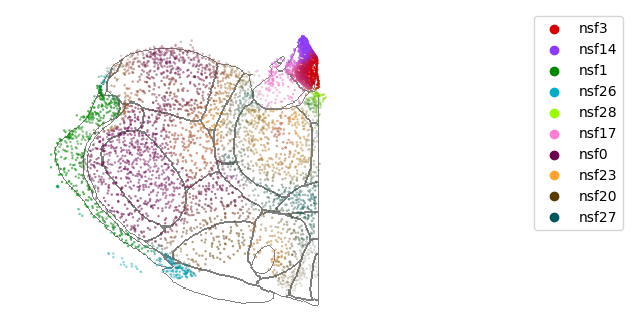

In [17]:

plot_patterns_overlay(obs, top_patterns.index[:10], section)
plt.savefig("/results/nsf_section_patterns_overlay.pdf", transparent=True)

In [18]:

kwargs = dict(
    section_col='z_section',
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=0.1, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

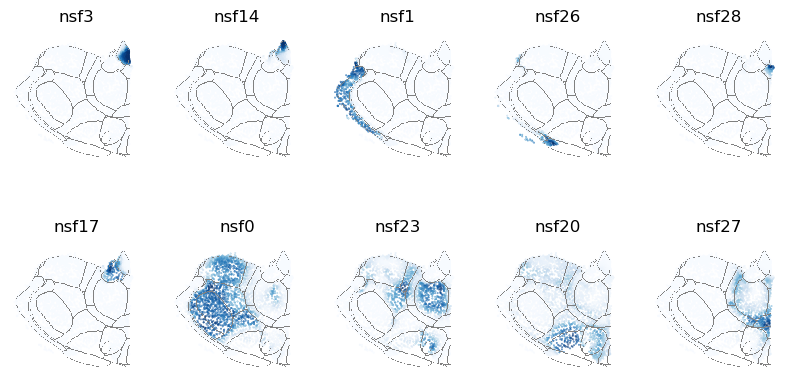

In [19]:
cols = top_patterns.index[:10]

fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.ravel()

for i, col in enumerate(cols):
    cplots.plot_expression_ccf_section(obs, col, ccf_polygons, section, ax=axes[i],
                                       colorbar=False, set_lims=[2.8, 5.8, 7, 4], **kwargs)
    # sns.scatterplot(df, hue=col, palette='Blues', ax=axes[i], **kwargs)
    # axes[i].invert_yaxis()
fig.savefig("/results/nsf_section_patterns_tiled.pdf", transparent=True)

In [20]:
# 13, 
patterns = [f"nsf{i}" for i in np.array([1,2,3,4,18,21,24,])-1]

## PP distance clustermaps

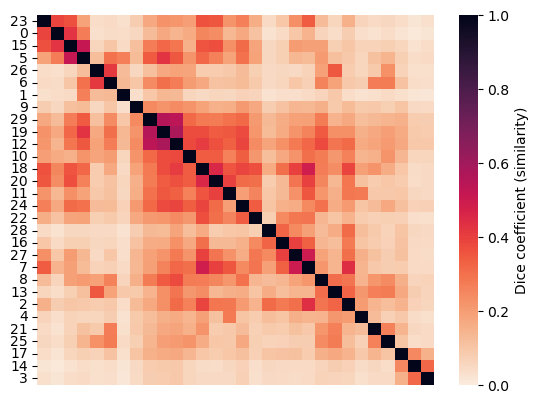

In [36]:
# y = ssd.pdist(factors, metric='braycurtis')
# dist = ssd.squareform(y)

# link = sch.linkage(y, method='complete', optimal_ordering=True)
# dend = sch.dendrogram(link, no_plot=True)
# nsf_order = dend["leaves"]

dist = pairwise_distances(factors, metric='braycurtis')
nsf_order = order_distances_by_clustering(dist)

plot_ordered_similarity_heatmap(dist, nsf_order)
# sns.heatmap(1-dist[np.ix_(nsf_order, nsf_order)], yticklabels=nsf_order, xticklabels=nsf_order,
#                 cbar_kws=dict(label="Dice coefficient (similarity)"), cmap='rocket_r', vmin=0, vmax=1)
# plt.savefig("/results/nsf_pattern_similarity.pdf", transparent=True)

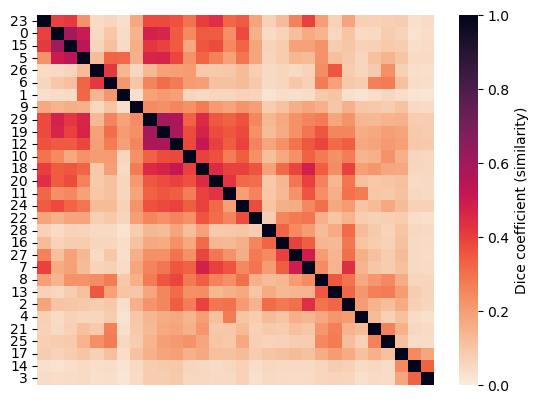

In [20]:
# unchanged
# y = ssd.pdist(factors * obs['nsf_tot'].values[None,:], metric='braycurtis')

# a bit closer to cosine
dist_norm = pairwise_distances(factors / factors.sum(axis=1, keepdims=True), 
                               metric='braycurtis')

plot_ordered_similarity_heatmap(dist_norm, nsf_order)

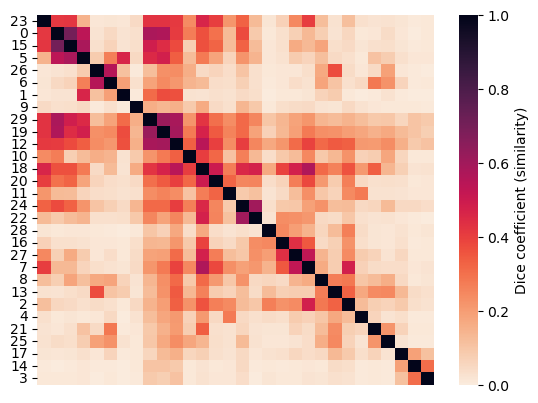

In [21]:
dist_cosine = pairwise_distances(factors, 
                               metric='cosine')

plot_ordered_similarity_heatmap(dist_cosine, nsf_order)

### gene loadings distance

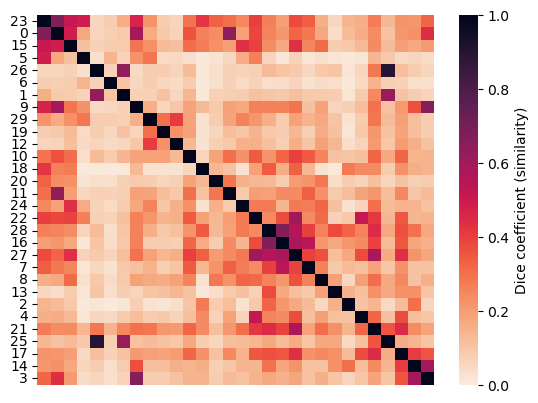

In [22]:
dist_genes = pairwise_distances(loadings, 
                               metric='cosine')

plot_ordered_similarity_heatmap(dist_genes, nsf_order)

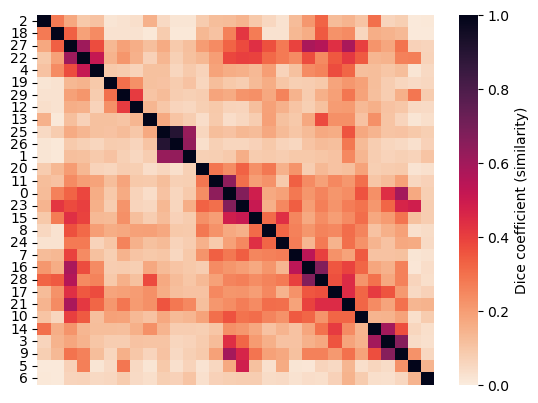

In [23]:
order = order_distances_by_clustering(dist_genes)
plot_ordered_similarity_heatmap(dist_genes, order)

## CCF overlap

In [37]:
# th_names = abc.get_thalamus_names(level='structure')
# th_subregion_names = list(set(th_names).difference(['TH-unassigned']))
# ccf_label = 'parcellation_structure_realigned'
# obs[ccf_label] = obs[ccf_label].str.replace('-unassigned','')

# for x in th_subregion_names:
#     obs[x] = obs[ccf_label] == x
# th_subregions_found = list(set(th_subregion_names).intersection(obs[ccf_label].unique()))
# obs[th_subregion_names].mean(axis=0).loc[lambda x: x==0]

In [38]:
regions_subset = np.array([
    'AD',
    'AV',
    'LD',
    'LGd',
    # VP combine?
    'VPM',
    'VPL',
    'AM',
    'VPMpc',
    'MD',
    'LP',
    'PO',
    'IAD',
    'VAL',
    'VM',
    'RE',
    'CL',
    'PF',
    'CM',
    'PCN',
    'SPA',
    'IMD',
    'PVT',
    # additional
    'MH',
    'LH',
    'RT',
    # 'ZI'
])

In [43]:
dist, y_names, x_names = cluster_distances_from_labels(obs, y_col=ccf_label, x_col=nsf_cols,
                                  y_names=regions_subset)
dist_nsf_ccf = dist.T[nsf_order,:]

In [44]:

# jaccard
# d = dist_nsf_ccf/(2-dist_nsf_ccf)

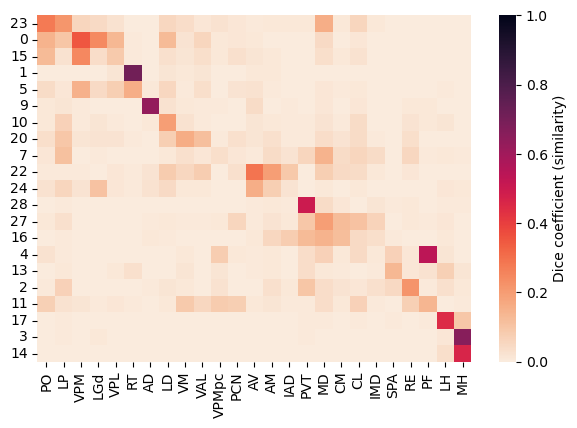

In [45]:
fig, ax = plt.subplots(figsize=(7,4.5))

subset = dist_nsf_ccf.min(axis=1) < 0.9

y_order, ccf_order = order_distances_x_to_y(dist_nsf_ccf[subset], reorder_y=True)
# ccf_order = plot_distances_sorted(dist_nsf_ccf[subset], nsf_order[subset], regions_subset, reorder_y=True)
plot_ordered_similarity_heatmap(dist_nsf_ccf[subset], 
                       y_order=y_order, x_order=ccf_order, 
                       y_names=nsf_order[subset], x_names=regions_subset)
# plt.savefig("/results/nsf_ccf_similarity.pdf")

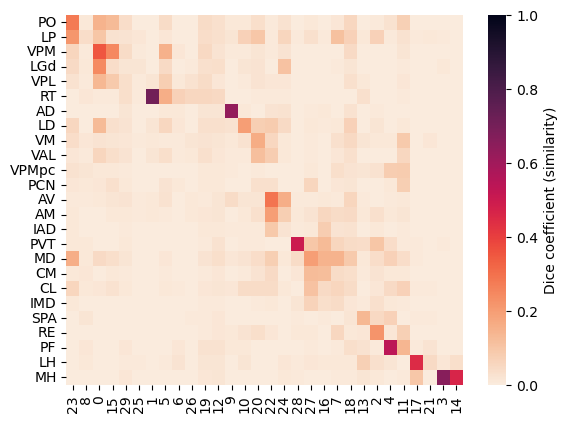

In [49]:
dist = dist_nsf_ccf[:,ccf_order].T
y_order, x_order = order_distances_x_to_y(dist, reorder_y=False)

plot_ordered_similarity_heatmap(dist, 
                       y_order=y_order, x_order=x_order, 
                       y_names=regions_subset[ccf_order], x_names=nsf_order)

In [36]:
# TODO: try clustering ccf on gene-space similarity (or spatial?) to order instead (sns.clustermap?)

## plotting individual patterns and genes

In [37]:

kwargs = dict(
    section_col='z_section',
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=1, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

In [38]:
# MD
# n=27, 7, 23 (or 0 for center)
n=7
# VM etc
# little gene overlap
# n=20


### AV

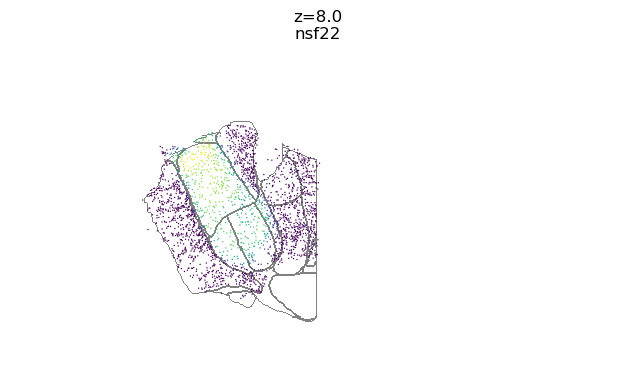

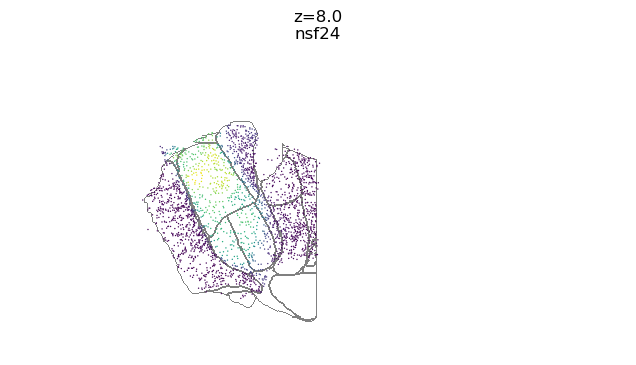

In [39]:
# AV
for n in [22, 24]:
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}', sections=[8.0],
                        point_palette='viridis', legend=None,
                        **kwargs);

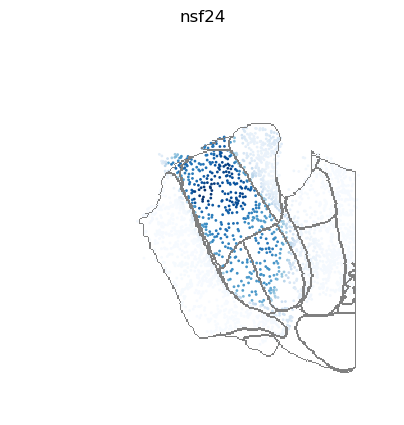

In [40]:

fig, ax = plt.subplots(figsize=(5,5))
cplots.plot_expression_ccf_section(adata.obs, "nsf24", ccf_polygons, 8.0, #ax=axes[i],
                                    colorbar=False, set_lims=[2.8, 5.8, 7, 4],
                                    ax=ax, **kwargs)
fig.savefig(f"/results/nsf_pattern_av.pdf", transparent=True)

In [41]:

diff_genes = adata.var["nsf22"] - adata.var["nsf24"]
(-diff_genes).sort_values(ascending=False).head()

gene_symbol
Ptprm     0.078538
Fras1     0.047932
Samd5     0.028425
Sox2      0.020889
Unc13c    0.020097
dtype: float32

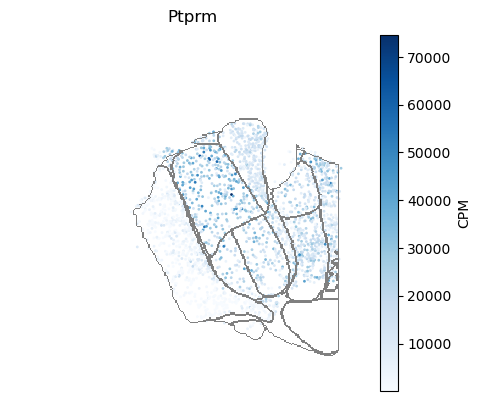

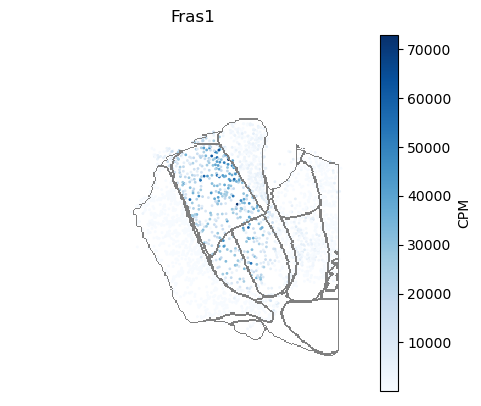

In [42]:
cols = (-diff_genes).sort_values(ascending=False).head(2).index
for i, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(5,5))
    adata.obs[col] = 2**adata[:,col].X.toarray().squeeze()
    cplots.plot_expression_ccf_section(adata.obs, col, ccf_polygons, 8.0, #ax=axes[i],
                                       colorbar=True, set_lims=[2.8, 5.8, 7, 4], label="CPM",
                                       ax=ax, **kwargs)
    fig.savefig(f"/results/nsf_genes_AV_{col}.pdf", transparent=True)

In [43]:

diff_genes = adata.var["nsf22"] - adata.var["nsf24"]
(diff_genes).sort_values(ascending=False).head()

gene_symbol
Stxbp6     0.085414
Cbln1      0.052562
Shox2      0.051853
Galnt18    0.035153
Spock3     0.031545
dtype: float32

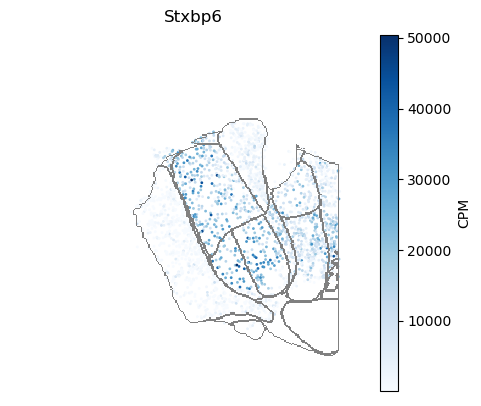

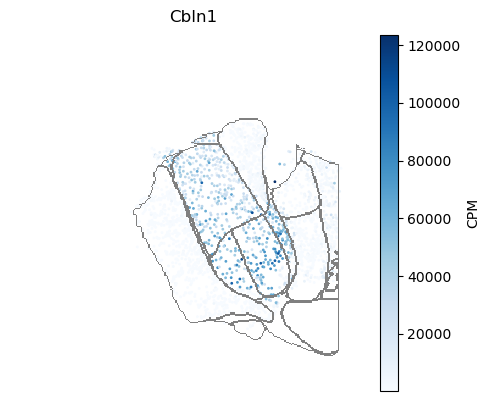

In [44]:
cols = diff_genes.sort_values(ascending=False).head(2).index
for i, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(5,5))
    adata.obs[col] = 2**adata[:,col].X.toarray().squeeze()
    cplots.plot_expression_ccf_section(adata.obs, col, ccf_polygons, 8.0, #ax=axes[i],
                                       colorbar=True, set_lims=[2.8, 5.8, 7, 4], label="CPM",
                                       ax=ax, **kwargs)
    fig.savefig(f"/results/nsf_genes_AV_{col}.pdf", transparent=True)

### MD

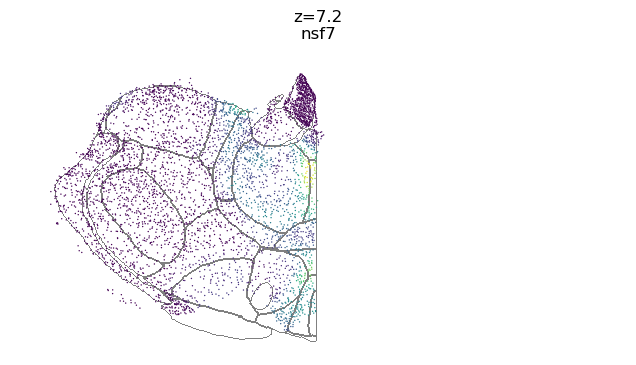

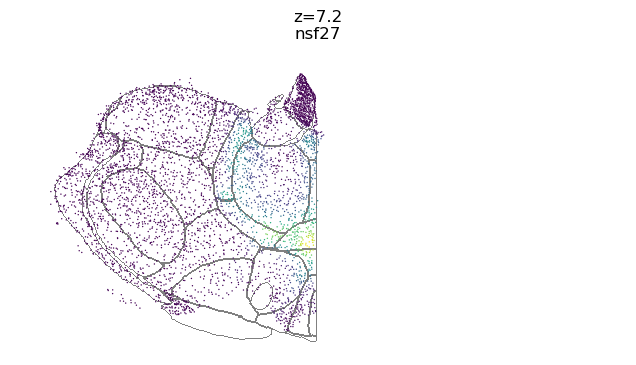

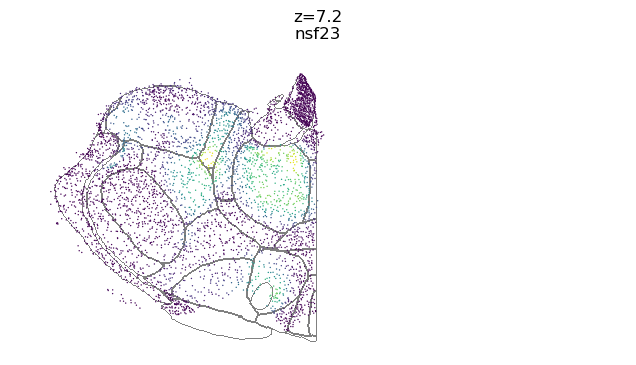

In [45]:
for n in [7, 27, 23]:
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}', sections=[section],
                        point_palette='viridis', legend=None,
                        **kwargs);

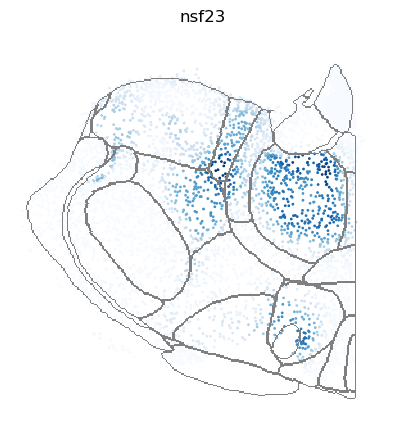

In [46]:

fig, ax = plt.subplots(figsize=(5,5))
cplots.plot_expression_ccf_section(adata.obs, "nsf23", ccf_polygons, section, #ax=axes[i],
                                    colorbar=False, set_lims=[2.8, 5.8, 7, 4],
                                    ax=ax, **kwargs)
fig.savefig(f"/results/nsf_pattern_md.pdf", transparent=True)

In [47]:

diff_genes = adata.var["nsf23"] - adata.var["nsf27"] - adata.var["nsf7"]
diff_genes.sort_values(ascending=False).head()

gene_symbol
Pcp4l1     0.084168
Slc17a7    0.056106
Ramp3      0.044221
Grin2c     0.023872
Rasgrp1    0.021916
dtype: float32

In [48]:
reload(cplots)

<module 'thalamus_merfish_analysis.ccf_plots' from '/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py'>

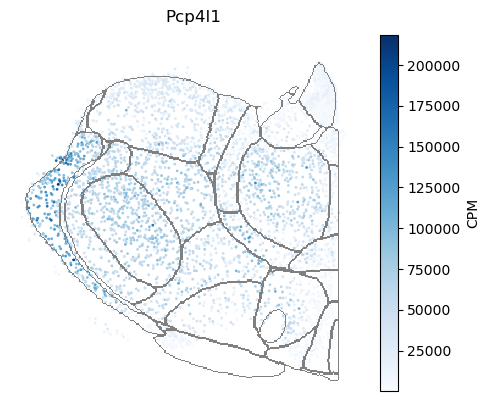

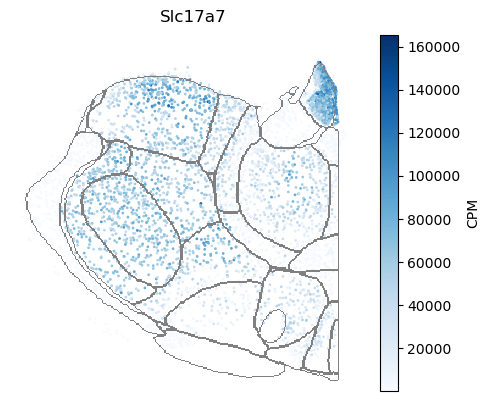

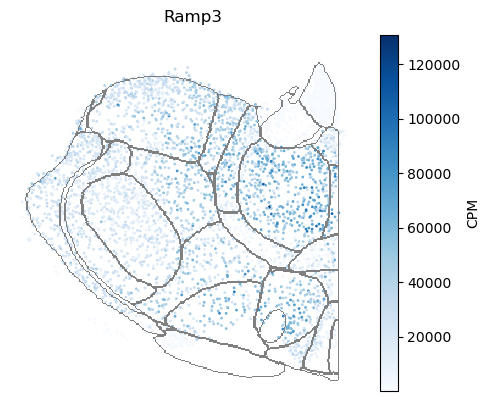

In [63]:
cols = diff_genes.sort_values(ascending=False).head(3).index
for i, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(5,5))
    adata.obs[col] = 2**adata[:,col].X.toarray().squeeze()
    cplots.plot_expression_ccf_section(adata.obs, col, ccf_polygons, section, #ax=axes[i],
                                       colorbar=True, set_lims=[2.8, 5.8, 7, 4], label="CPM",
                                       ax=ax, **kwargs)
    # fig.savefig(f"/results/nsf_genes_{col}.pdf", transparent=True)

## gene plots from loadings

Caution: Do not always look like factors!

In [50]:
loadings = adata.var[nsf_cols].to_numpy()
lin_weights = loadings @ np.linalg.pinv(loadings.T @ loadings)
# feat @ loadings.T = X, so feat ~= X @ lin_weights
adata.obsm['genes_on_loadings'] = adata.X @ loadings
adata.obsm['genes_linear_projection'] = adata.X @ lin_weights

In [51]:
N = loadings.shape[1]
# normalize by gene to compare patterns by gene?
# loadings_norm = loadings/loadings.sum(axis=1, keepdims=True)
loadings_norm = loadings
top_gene = np.zeros(N, dtype=int)
gene_prominence = np.zeros(N)
for n in range(N):
    pattern_prominence = loadings_norm[:,n] - np.delete(loadings_norm, n, axis=1).max(axis=1)
    n_gene = np.argmax(pattern_prominence)
    top_gene[n] = n_gene
    gene_prominence[n] = pattern_prominence[n_gene]
    obs[f"nsf{n}_1gene"] = 2**np.array(adata.X[:,n_gene])

/tmp/ipykernel_27928/896334470.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[f"nsf{n}_1gene"] = 2**np.array(adata.X[:,n_gene])
/tmp/ipykernel_27928/896334470.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[f"nsf{n}_1gene"] = 2**np.array(adata.X[:,n_gene])
/tmp/ipykernel_27928/896334470.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

In [52]:
np.nonzero(gene_prominence>0.1)

(array([ 2,  5,  6, 10, 11, 12, 18, 20]),)

In [53]:
(top_gene == loadings.argmax(axis=0))[np.nonzero(gene_prominence>0.1)]

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [54]:

kwargs = dict(
    section_col='z_section',
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=1, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

### AV

Stxbp6


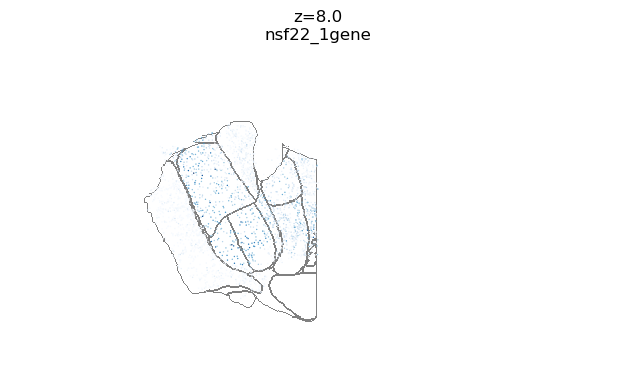

Ptprm


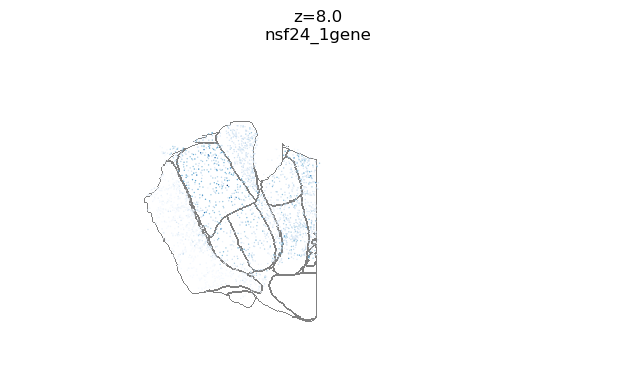

In [55]:
for n in[22, 24]:
    print(adata.var_names[top_gene[n]])
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_1gene', sections=[8.0], 
                        point_palette='Blues', legend=None, 
                        **kwargs);

### MD

Necab1


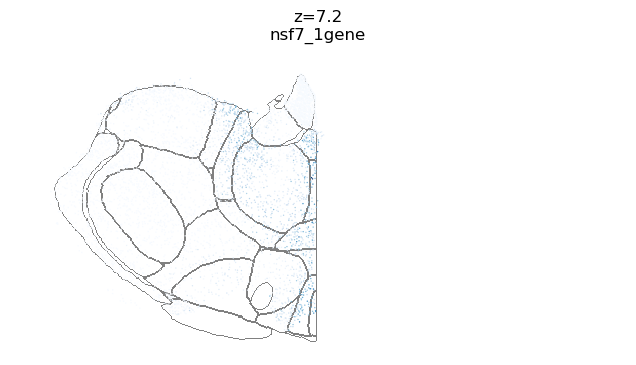

Rxfp1


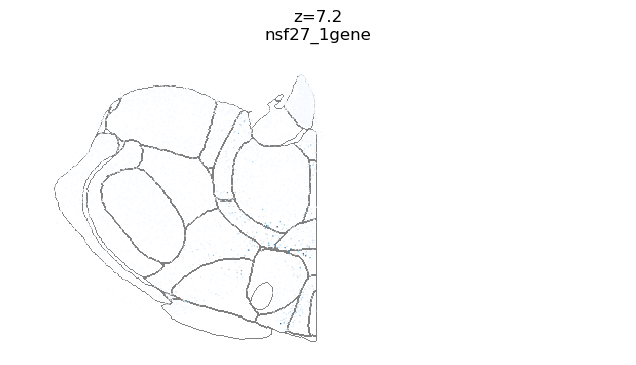

Ramp3


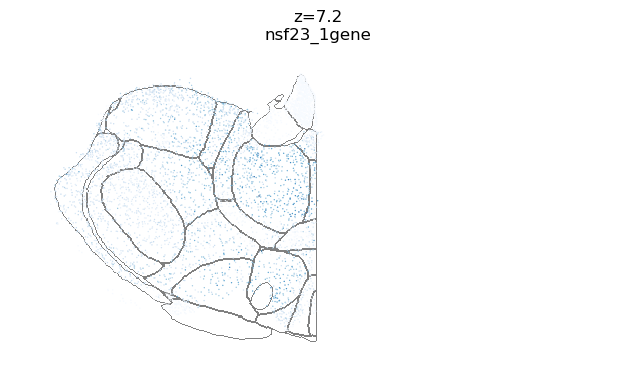

In [56]:
for n in[7, 27, 23]:
    print(adata.var_names[top_gene[n]])
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_1gene', sections=[section], 
                        point_palette='Blues', legend=None, 
                        **kwargs);

In [57]:
# can't plot with obsm currently

# cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
#                         point_hue=adata.obsm['genes_on_loadings'][:,0], 
#                         sections=sections_3,
#                         shape_palette='dark_outline', 
#                         point_palette='viridis', legend=None, 
#                         section_col=section_col, 
#                         x_col=x_coord_col, y_col=y_coord_col, s=3,
#                         boundary_img=ccf_boundaries);

In [58]:

for i, x in enumerate(nsf_cols):
    l = adata.var[x].to_numpy()[:,None]
    obs[x+"_allgenes"] = adata.X @ l
    order = l.argsort()
    l[order[:-3]] = 0
    obs[x+"_3genes"] = adata.X @ l
    l[order[:-2]] = 0
    obs[x+"_2genes"] = adata.X @ l
    obs[x+"_linear_genes"] = adata.X @ lin_weights[:,[i]]


/tmp/ipykernel_27928/3303959001.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[x+"_allgenes"] = adata.X @ l
/tmp/ipykernel_27928/3303959001.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  obs[x+"_3genes"] = adata.X @ l
/tmp/ipykernel_27928/3303959001.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

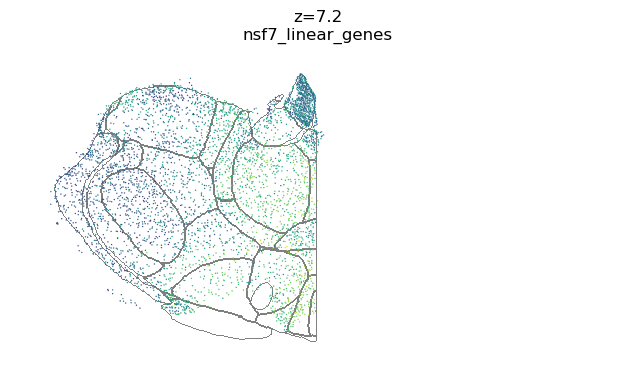

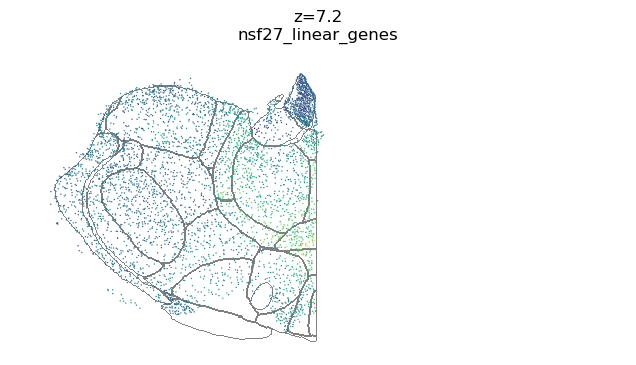

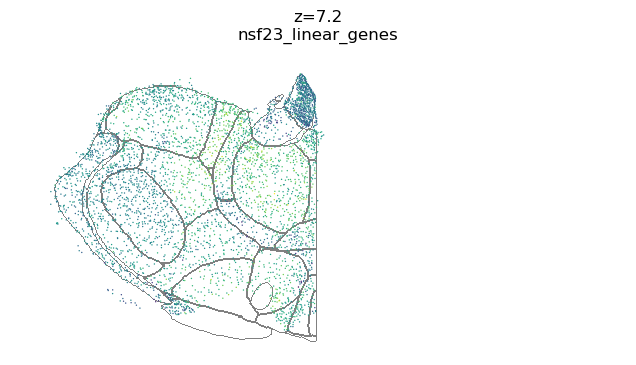

In [59]:
for n in[7, 27, 23]:
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_linear_genes', sections=[section], 
                        point_palette='viridis', legend=None, 
                        **kwargs);

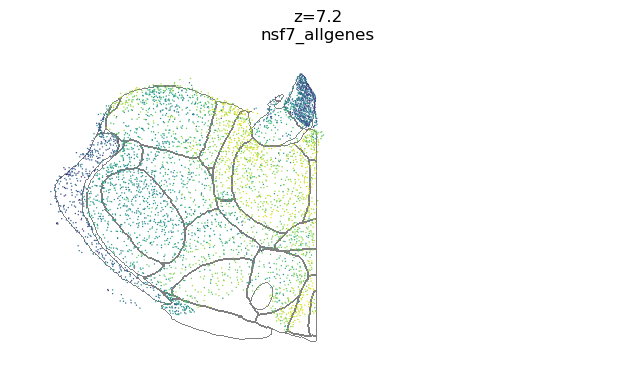

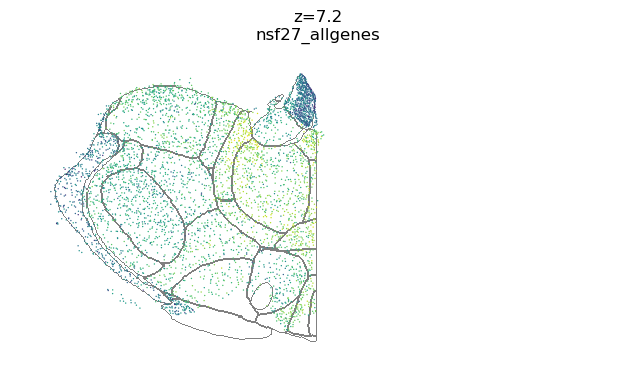

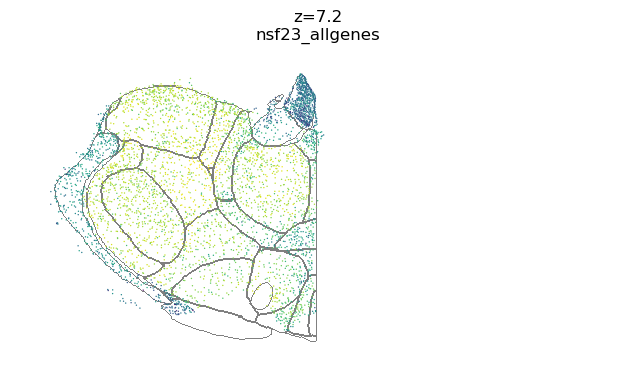

In [60]:
for n in[7, 27, 23]:
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_allgenes', sections=[section], 
                        point_palette='viridis', legend=None, 
                        **kwargs);

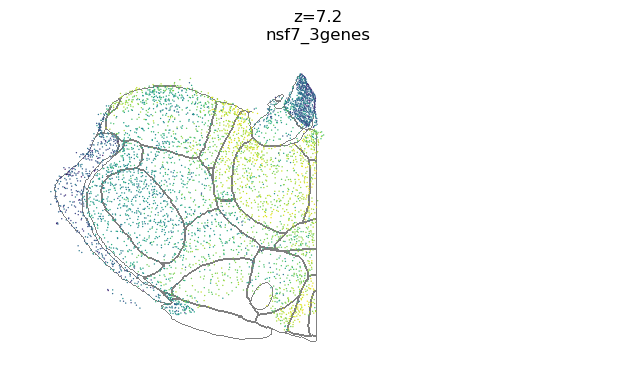

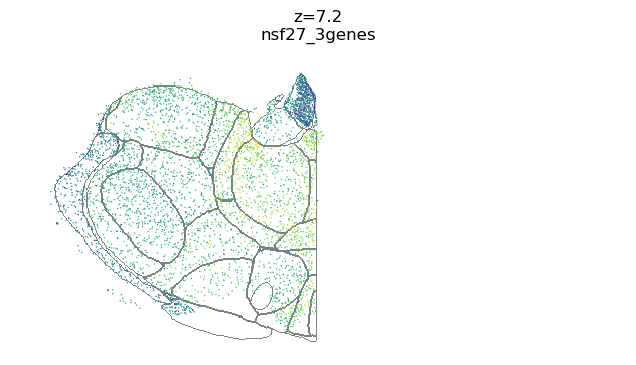

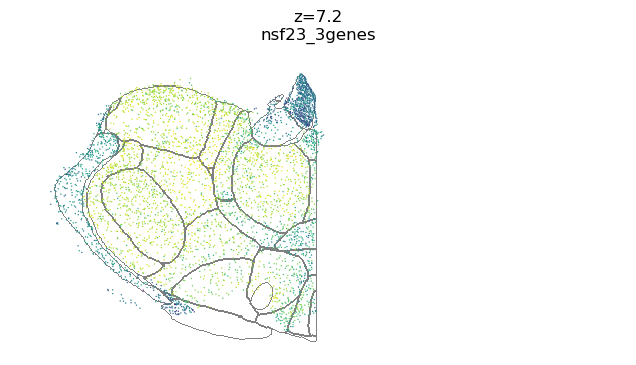

In [61]:
for n in[7, 27, 23]:
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_3genes', sections=[section], 
                        point_palette='viridis', legend=None, 
                        **kwargs);

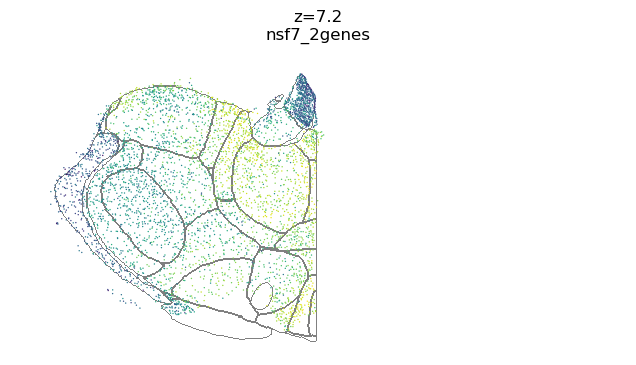

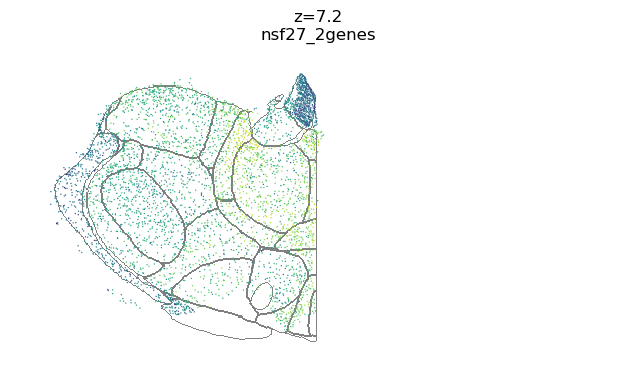

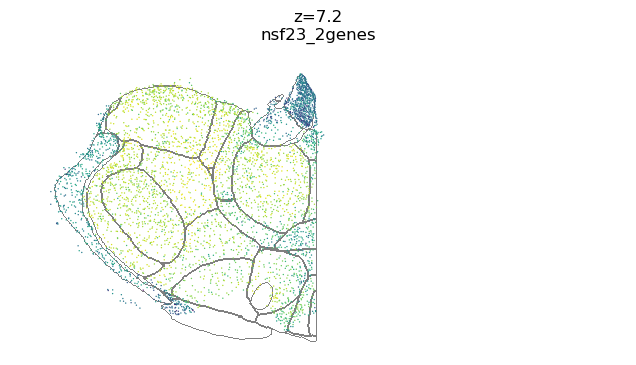

In [62]:
for n in[7, 27, 23]:
    cplots.plot_ccf_overlay(obs, ccf_polygons, categorical=False,
                        point_hue=f'nsf{n}_2genes', sections=[section], 
                        point_palette='viridis', legend=None, 
                        **kwargs);